In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import joblib
import warnings
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, make_scorer
)
from scipy.stats import uniform, loguniform
import time

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Libraries berhasil di-import!")

✅ Libraries berhasil di-import!


In [26]:
print("="*80)
print("LOADING PREPROCESSED DATA (SCALED)")
print("="*80)

# Load SCALED data (PENTING untuk SVM!)
data_scaled = np.load('../data/processed/train_test_split_scaled.npz')
X_train_scaled = data_scaled['X_train_scaled']
X_test_scaled = data_scaled['X_test_scaled']
y_train = data_scaled['y_train']
y_test = data_scaled['y_test']

# Load metadata
with open('../data/processed/preprocessing_objects.pkl', 'rb') as f:
    prep_objects = pickle.load(f)

feature_names = prep_objects['feature_names']
target_col = prep_objects['target_column']

print(f"✅ SCALED data loaded successfully!")
print(f"\n📊 Dataset Info:")
print(f"  • X_train_scaled shape: {X_train_scaled.shape}")
print(f"  • X_test_scaled shape: {X_test_scaled.shape}")
print(f"  • y_train shape: {y_train.shape}")
print(f"  • y_test shape: {y_test.shape}")
print(f"  • Total features: {X_train_scaled.shape[1]}")
print(f"  • Target: {target_col}")

# Load baseline results untuk comparison
baseline_results = pd.read_csv('../results/metrics/baseline_models_results.csv')
best_baseline_acc = baseline_results['Test_Accuracy'].max() * 100
best_baseline_model = baseline_results.loc[baseline_results['Test_Accuracy'].idxmax(), 'Model']

print(f"\n🎯 TARGET TO BEAT:")
print(f"  • Best Baseline: {best_baseline_model}")
print(f"  • Accuracy: {best_baseline_acc:.2f}%")

# Grade mapping untuk interpretasi
grade_mapping = {0: 'Fail', 1: 'DD', 2: 'DC', 3: 'CC', 4: 'CB', 5: 'BB', 6: 'BA', 7: 'AA'}

LOADING PREPROCESSED DATA (SCALED)
✅ SCALED data loaded successfully!

📊 Dataset Info:
  • X_train_scaled shape: (116, 32)
  • X_test_scaled shape: (29, 32)
  • y_train shape: (116,)
  • y_test shape: (29,)
  • Total features: 32
  • Target: GRADE

🎯 TARGET TO BEAT:
  • Best Baseline: K-Nearest Neighbors (KNN)
  • Accuracy: 81.00%


In [27]:
print("\n" + "="*80)
print("UNDERSTANDING SUPPORT VECTOR MACHINE (SVM)")
print("="*80)

print("""
📚 KONSEP SVM:
Support Vector Machine (SVM) adalah algoritma supervised learning yang mencari 
hyperplane terbaik untuk memisahkan kelas-kelas data.

🔑 KEY CONCEPTS:
1. Hyperplane: Boundary yang memisahkan kelas
2. Support Vectors: Data points terdekat dengan hyperplane
3. Margin: Jarak antara hyperplane dan support vectors
4. Kernel Trick: Mengubah data ke dimensi lebih tinggi

🎯 TUJUAN SVM:
Maksimalkan margin → Model lebih robust dan generalize better

⚙️ HYPERPARAMETERS PENTING:
1. C (Regularization): 
   - C kecil: Margin lebar, toleran terhadap misclassification
   - C besar: Margin sempit, strict classification
   
2. Kernel: Fungsi untuk transformasi data
   - Linear: Data linearly separable
   - RBF (Radial Basis Function): Data non-linear (paling umum)
   - Polynomial: Data dengan polynomial patterns
   - Sigmoid: Mirip neural network
   
3. Gamma (untuk RBF & Poly):
   - Gamma kecil: Decision boundary smooth
   - Gamma besar: Decision boundary complex (risk overfitting)

4. Degree (untuk Polynomial):
   - Degree of polynomial kernel function
""")


UNDERSTANDING SUPPORT VECTOR MACHINE (SVM)

📚 KONSEP SVM:
Support Vector Machine (SVM) adalah algoritma supervised learning yang mencari 
hyperplane terbaik untuk memisahkan kelas-kelas data.

🔑 KEY CONCEPTS:
1. Hyperplane: Boundary yang memisahkan kelas
2. Support Vectors: Data points terdekat dengan hyperplane
3. Margin: Jarak antara hyperplane dan support vectors
4. Kernel Trick: Mengubah data ke dimensi lebih tinggi

🎯 TUJUAN SVM:
Maksimalkan margin → Model lebih robust dan generalize better

⚙️ HYPERPARAMETERS PENTING:
1. C (Regularization): 
   - C kecil: Margin lebar, toleran terhadap misclassification
   - C besar: Margin sempit, strict classification

2. Kernel: Fungsi untuk transformasi data
   - Linear: Data linearly separable
   - RBF (Radial Basis Function): Data non-linear (paling umum)
   - Polynomial: Data dengan polynomial patterns
   - Sigmoid: Mirip neural network

3. Gamma (untuk RBF & Poly):
   - Gamma kecil: Decision boundary smooth
   - Gamma besar: Decision bou

In [28]:
print("\n" + "="*80)
print("EXPERIMENT 1: SVM with LINEAR KERNEL")
print("="*80)

print("\n🔧 Konfigurasi:")
print("  • Kernel: Linear")
print("  • Hyperparameter: C (regularization)")
print("  • Asumsi: Data linearly separable")

# Define parameter grid for Linear SVM
param_grid_linear = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'class_weight': ['balanced', None]
}

print(f"  • Parameter grid: {param_grid_linear}")
print(f"  • Total combinations: {len(param_grid_linear['C']) * len(param_grid_linear['class_weight'])}")

# GridSearchCV for Linear SVM
print("\n🔍 Hyperparameter Tuning dengan GridSearchCV (5-fold CV)...")
svm_linear_base = SVC(kernel='linear', random_state=42)
grid_linear = GridSearchCV(
    svm_linear_base,
    param_grid_linear,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

start_time = time.time()
grid_linear.fit(X_train_scaled, y_train)
train_time_linear = time.time() - start_time

print(f"\n✅ Training completed in {train_time_linear:.2f} seconds")

# Best parameters
print(f"\n🏆 Best Parameters:")
for param, value in grid_linear.best_params_.items():
    print(f"  • {param}: {value}")
print(f"  • Best CV Score: {grid_linear.best_score_*100:.2f}%")

# Evaluate on test set
svm_linear = grid_linear.best_estimator_
y_pred_linear = svm_linear.predict(X_test_scaled)

# Calculate metrics
linear_metrics = {
    'Model': 'SVM (Linear)',
    'Kernel': 'linear',
    'Best_C': grid_linear.best_params_['C'],
    'CV_Score': grid_linear.best_score_,
    'Train_Accuracy': svm_linear.score(X_train_scaled, y_train),
    'Test_Accuracy': accuracy_score(y_test, y_pred_linear),
    'Precision': precision_score(y_test, y_pred_linear, average='weighted', zero_division=0),
    'Recall': recall_score(y_test, y_pred_linear, average='weighted', zero_division=0),
    'F1_Score': f1_score(y_test, y_pred_linear, average='weighted', zero_division=0),
    'Train_Time': train_time_linear
}

print(f"\n📊 RESULTS - SVM Linear:")
print(f"  • Train Accuracy: {linear_metrics['Train_Accuracy']*100:.2f}%")
print(f"  • Test Accuracy:  {linear_metrics['Test_Accuracy']*100:.2f}%")
print(f"  • Precision:      {linear_metrics['Precision']*100:.2f}%")
print(f"  • Recall:         {linear_metrics['Recall']*100:.2f}%")
print(f"  • F1-Score:       {linear_metrics['F1_Score']*100:.2f}%")

# Check overfitting
overfit_gap = linear_metrics['Train_Accuracy'] - linear_metrics['Test_Accuracy']
if overfit_gap > 0.1:
    print(f"\n⚠️  Possible overfitting (gap: {overfit_gap*100:.2f}%)")
else:
    print(f"\n✅ Good generalization (gap: {overfit_gap*100:.2f}%)")

# Classification report
print(f"\n📋 CLASSIFICATION REPORT:")
class_names = [grade_mapping.get(i, f'Class_{i}') for i in sorted(np.unique(y_test))]
print(classification_report(y_test, y_pred_linear, target_names=class_names, zero_division=0))


EXPERIMENT 1: SVM with LINEAR KERNEL

🔧 Konfigurasi:
  • Kernel: Linear
  • Hyperparameter: C (regularization)
  • Asumsi: Data linearly separable
  • Parameter grid: {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'class_weight': ['balanced', None]}
  • Total combinations: 14

🔍 Hyperparameter Tuning dengan GridSearchCV (5-fold CV)...
Fitting 5 folds for each of 14 candidates, totalling 70 fits

✅ Training completed in 5.15 seconds

🏆 Best Parameters:
  • C: 0.001
  • class_weight: None
  • Best CV Score: 24.17%

📊 RESULTS - SVM Linear:
  • Train Accuracy: 24.14%
  • Test Accuracy:  24.14%
  • Precision:      5.83%
  • Recall:         24.14%
  • F1-Score:       9.39%

✅ Good generalization (gap: 0.00%)

📋 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

        Fail       0.00      0.00      0.00         2
          DD       0.24      1.00      0.39         7
          DC       0.00      0.00      0.00         5
          CC       0.00      0.00      0.00    

In [29]:
print("\n" + "="*80)
print("EXPERIMENT 2: SVM with RBF KERNEL")
print("="*80)

print("\n🔧 Konfigurasi:")
print("  • Kernel: RBF (Radial Basis Function)")
print("  • Hyperparameter: C, gamma")
print("  • Best for: Non-linear data")

# Define parameter grid for RBF SVM
# Strategy: Coarse to fine grid search
param_grid_rbf = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
    'class_weight': ['balanced', None]
}

print(f"  • Parameter grid: {param_grid_rbf}")
total_combinations = len(param_grid_rbf['C']) * len(param_grid_rbf['gamma']) * len(param_grid_rbf['class_weight'])
print(f"  • Total combinations: {total_combinations}")
print(f"  • Estimated time: ~{total_combinations * 2 // 60} minutes (with 5-fold CV)")

# GridSearchCV for RBF SVM
print("\n🔍 Hyperparameter Tuning dengan GridSearchCV (5-fold CV)...")
print("⏳ This will take several minutes... Please be patient!")

svm_rbf_base = SVC(kernel='rbf', random_state=42)
grid_rbf = GridSearchCV(
    svm_rbf_base,
    param_grid_rbf,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

start_time = time.time()
grid_rbf.fit(X_train_scaled, y_train)
train_time_rbf = time.time() - start_time

print(f"\n✅ Training completed in {train_time_rbf:.2f} seconds ({train_time_rbf/60:.2f} minutes)")

# Best parameters
print(f"\n🏆 Best Parameters:")
for param, value in grid_rbf.best_params_.items():
    print(f"  • {param}: {value}")
print(f"  • Best CV Score: {grid_rbf.best_score_*100:.2f}%")

# Evaluate on test set
svm_rbf = grid_rbf.best_estimator_
y_pred_rbf = svm_rbf.predict(X_test_scaled)

# Calculate metrics
rbf_metrics = {
    'Model': 'SVM (RBF)',
    'Kernel': 'rbf',
    'Best_C': grid_rbf.best_params_['C'],
    'Best_gamma': grid_rbf.best_params_['gamma'],
    'CV_Score': grid_rbf.best_score_,
    'Train_Accuracy': svm_rbf.score(X_train_scaled, y_train),
    'Test_Accuracy': accuracy_score(y_test, y_pred_rbf),
    'Precision': precision_score(y_test, y_pred_rbf, average='weighted', zero_division=0),
    'Recall': recall_score(y_test, y_pred_rbf, average='weighted', zero_division=0),
    'F1_Score': f1_score(y_test, y_pred_rbf, average='weighted', zero_division=0),
    'Train_Time': train_time_rbf
}

print(f"\n📊 RESULTS - SVM RBF:")
print(f"  • Train Accuracy: {rbf_metrics['Train_Accuracy']*100:.2f}%")
print(f"  • Test Accuracy:  {rbf_metrics['Test_Accuracy']*100:.2f}%")
print(f"  • Precision:      {rbf_metrics['Precision']*100:.2f}%")
print(f"  • Recall:         {rbf_metrics['Recall']*100:.2f}%")
print(f"  • F1-Score:       {rbf_metrics['F1_Score']*100:.2f}%")

# Check overfitting
overfit_gap = rbf_metrics['Train_Accuracy'] - rbf_metrics['Test_Accuracy']
if overfit_gap > 0.1:
    print(f"\n⚠️  Possible overfitting (gap: {overfit_gap*100:.2f}%)")
else:
    print(f"\n✅ Good generalization (gap: {overfit_gap*100:.2f}%)")

# Classification report
print(f"\n📋 CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_rbf, target_names=class_names, zero_division=0))


EXPERIMENT 2: SVM with RBF KERNEL

🔧 Konfigurasi:
  • Kernel: RBF (Radial Basis Function)
  • Hyperparameter: C, gamma
  • Best for: Non-linear data
  • Parameter grid: {'C': [0.1, 1, 10, 100, 1000], 'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1], 'class_weight': ['balanced', None]}
  • Total combinations: 60
  • Estimated time: ~2 minutes (with 5-fold CV)

🔍 Hyperparameter Tuning dengan GridSearchCV (5-fold CV)...
⏳ This will take several minutes... Please be patient!
Fitting 5 folds for each of 60 candidates, totalling 300 fits

✅ Training completed in 0.27 seconds (0.00 minutes)

🏆 Best Parameters:
  • C: 1
  • class_weight: balanced
  • gamma: 0.1
  • Best CV Score: 25.00%

📊 RESULTS - SVM RBF:
  • Train Accuracy: 100.00%
  • Test Accuracy:  24.14%
  • Precision:      6.03%
  • Recall:         24.14%
  • F1-Score:       9.66%

⚠️  Possible overfitting (gap: 75.86%)

📋 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

        Fail       0.00      0.00  

In [6]:
print("\n" + "="*80)
print("EXPERIMENT 3: SVM with POLYNOMIAL KERNEL")
print("="*80)

print("\n🔧 Konfigurasi:")
print("  • Kernel: Polynomial")
print("  • Hyperparameter: C, degree, gamma")
print("  • Best for: Polynomial relationships")

# Define parameter grid for Polynomial SVM
param_grid_poly = {
    'C': [0.1, 1, 10, 100],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto'],
    'coef0': [0, 1],
    'class_weight': ['balanced', None]
}

print(f"  • Parameter grid: {param_grid_poly}")
total_combinations = (len(param_grid_poly['C']) * len(param_grid_poly['degree']) * 
                     len(param_grid_poly['gamma']) * len(param_grid_poly['coef0']) * 
                     len(param_grid_poly['class_weight']))
print(f"  • Total combinations: {total_combinations}")

# GridSearchCV for Polynomial SVM
print("\n🔍 Hyperparameter Tuning dengan GridSearchCV (5-fold CV)...")
print("⏳ This will take several minutes...")

svm_poly_base = SVC(kernel='poly', random_state=42)
grid_poly = GridSearchCV(
    svm_poly_base,
    param_grid_poly,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

start_time = time.time()
grid_poly.fit(X_train_scaled, y_train)
train_time_poly = time.time() - start_time

print(f"\n✅ Training completed in {train_time_poly:.2f} seconds ({train_time_poly/60:.2f} minutes)")

# Best parameters
print(f"\n🏆 Best Parameters:")
for param, value in grid_poly.best_params_.items():
    print(f"  • {param}: {value}")
print(f"  • Best CV Score: {grid_poly.best_score_*100:.2f}%")

# Evaluate on test set
svm_poly = grid_poly.best_estimator_
y_pred_poly = svm_poly.predict(X_test_scaled)

# Calculate metrics
poly_metrics = {
    'Model': 'SVM (Polynomial)',
    'Kernel': 'poly',
    'Best_C': grid_poly.best_params_['C'],
    'Best_degree': grid_poly.best_params_['degree'],
    'Best_gamma': grid_poly.best_params_['gamma'],
    'CV_Score': grid_poly.best_score_,
    'Train_Accuracy': svm_poly.score(X_train_scaled, y_train),
    'Test_Accuracy': accuracy_score(y_test, y_pred_poly),
    'Precision': precision_score(y_test, y_pred_poly, average='weighted', zero_division=0),
    'Recall': recall_score(y_test, y_pred_poly, average='weighted', zero_division=0),
    'F1_Score': f1_score(y_test, y_pred_poly, average='weighted', zero_division=0),
    'Train_Time': train_time_poly
}

print(f"\n📊 RESULTS - SVM Polynomial:")
print(f"  • Train Accuracy: {poly_metrics['Train_Accuracy']*100:.2f}%")
print(f"  • Test Accuracy:  {poly_metrics['Test_Accuracy']*100:.2f}%")
print(f"  • Precision:      {poly_metrics['Precision']*100:.2f}%")
print(f"  • Recall:         {poly_metrics['Recall']*100:.2f}%")
print(f"  • F1-Score:       {poly_metrics['F1_Score']*100:.2f}%")

# Check overfitting
overfit_gap = poly_metrics['Train_Accuracy'] - poly_metrics['Test_Accuracy']
if overfit_gap > 0.1:
    print(f"\n⚠️  Possible overfitting (gap: {overfit_gap*100:.2f}%)")
else:
    print(f"\n✅ Good generalization (gap: {overfit_gap*100:.2f}%)")

# Classification report
print(f"\n📋 CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_poly, target_names=class_names, zero_division=0))


EXPERIMENT 3: SVM with POLYNOMIAL KERNEL

🔧 Konfigurasi:
  • Kernel: Polynomial
  • Hyperparameter: C, degree, gamma
  • Best for: Polynomial relationships
  • Parameter grid: {'C': [0.1, 1, 10, 100], 'degree': [2, 3, 4], 'gamma': ['scale', 'auto'], 'coef0': [0, 1], 'class_weight': ['balanced', None]}
  • Total combinations: 96

🔍 Hyperparameter Tuning dengan GridSearchCV (5-fold CV)...
⏳ This will take several minutes...
Fitting 5 folds for each of 96 candidates, totalling 480 fits

✅ Training completed in 0.45 seconds (0.01 minutes)

🏆 Best Parameters:
  • C: 10
  • class_weight: None
  • coef0: 0
  • degree: 3
  • gamma: scale
  • Best CV Score: 27.64%

📊 RESULTS - SVM Polynomial:
  • Train Accuracy: 100.00%
  • Test Accuracy:  24.14%
  • Precision:      12.41%
  • Recall:         24.14%
  • F1-Score:       14.87%

⚠️  Possible overfitting (gap: 75.86%)

📋 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

        Fail       0.00      0.00      0.00      

In [7]:
print("\n" + "="*80)
print("EXPERIMENT 4: SVM with SIGMOID KERNEL")
print("="*80)

print("\n🔧 Konfigurasi:")
print("  • Kernel: Sigmoid")
print("  • Hyperparameter: C, gamma")
print("  • Similar to: Neural Network activation")

# Define parameter grid for Sigmoid SVM
param_grid_sigmoid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01, 0.1],
    'coef0': [0, 1],
    'class_weight': ['balanced', None]
}

print(f"  • Parameter grid: {param_grid_sigmoid}")
total_combinations = (len(param_grid_sigmoid['C']) * len(param_grid_sigmoid['gamma']) * 
                     len(param_grid_sigmoid['coef0']) * len(param_grid_sigmoid['class_weight']))
print(f"  • Total combinations: {total_combinations}")

# GridSearchCV for Sigmoid SVM
print("\n🔍 Hyperparameter Tuning dengan GridSearchCV (5-fold CV)...")

svm_sigmoid_base = SVC(kernel='sigmoid', random_state=42)
grid_sigmoid = GridSearchCV(
    svm_sigmoid_base,
    param_grid_sigmoid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

start_time = time.time()
grid_sigmoid.fit(X_train_scaled, y_train)
train_time_sigmoid = time.time() - start_time

print(f"\n✅ Training completed in {train_time_sigmoid:.2f} seconds")

# Best parameters
print(f"\n🏆 Best Parameters:")
for param, value in grid_sigmoid.best_params_.items():
    print(f"  • {param}: {value}")
print(f"  • Best CV Score: {grid_sigmoid.best_score_*100:.2f}%")

# Evaluate on test set
svm_sigmoid = grid_sigmoid.best_estimator_
y_pred_sigmoid = svm_sigmoid.predict(X_test_scaled)

# Calculate metrics
sigmoid_metrics = {
    'Model': 'SVM (Sigmoid)',
    'Kernel': 'sigmoid',
    'Best_C': grid_sigmoid.best_params_['C'],
    'Best_gamma': grid_sigmoid.best_params_['gamma'],
    'CV_Score': grid_sigmoid.best_score_,
    'Train_Accuracy': svm_sigmoid.score(X_train_scaled, y_train),
    'Test_Accuracy': accuracy_score(y_test, y_pred_sigmoid),
    'Precision': precision_score(y_test, y_pred_sigmoid, average='weighted', zero_division=0),
    'Recall': recall_score(y_test, y_pred_sigmoid, average='weighted', zero_division=0),
    'F1_Score': f1_score(y_test, y_pred_sigmoid, average='weighted', zero_division=0),
    'Train_Time': train_time_sigmoid
}

print(f"\n📊 RESULTS - SVM Sigmoid:")
print(f"  • Train Accuracy: {sigmoid_metrics['Train_Accuracy']*100:.2f}%")
print(f"  • Test Accuracy:  {sigmoid_metrics['Test_Accuracy']*100:.2f}%")
print(f"  • Precision:      {sigmoid_metrics['Precision']*100:.2f}%")
print(f"  • Recall:         {sigmoid_metrics['Recall']*100:.2f}%")
print(f"  • F1-Score:       {sigmoid_metrics['F1_Score']*100:.2f}%")

# Check overfitting
overfit_gap = sigmoid_metrics['Train_Accuracy'] - sigmoid_metrics['Test_Accuracy']
if overfit_gap > 0.1:
    print(f"\n⚠️  Possible overfitting (gap: {overfit_gap*100:.2f}%)")
else:
    print(f"\n✅ Good generalization (gap: {overfit_gap*100:.2f}%)")

# Classification report
print(f"\n📋 CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_sigmoid, target_names=class_names, zero_division=0))


EXPERIMENT 4: SVM with SIGMOID KERNEL

🔧 Konfigurasi:
  • Kernel: Sigmoid
  • Hyperparameter: C, gamma
  • Similar to: Neural Network activation
  • Parameter grid: {'C': [0.1, 1, 10, 100], 'gamma': ['scale', 'auto', 0.01, 0.1], 'coef0': [0, 1], 'class_weight': ['balanced', None]}
  • Total combinations: 64

🔍 Hyperparameter Tuning dengan GridSearchCV (5-fold CV)...
Fitting 5 folds for each of 64 candidates, totalling 320 fits

✅ Training completed in 0.35 seconds

🏆 Best Parameters:
  • C: 100
  • class_weight: balanced
  • coef0: 0
  • gamma: 0.01
  • Best CV Score: 25.94%

📊 RESULTS - SVM Sigmoid:
  • Train Accuracy: 94.83%
  • Test Accuracy:  31.03%
  • Precision:      24.83%
  • Recall:         31.03%
  • F1-Score:       27.50%

⚠️  Possible overfitting (gap: 63.79%)

📋 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

        Fail       0.50      0.50      0.50         2
          DD       0.30      0.43      0.35         7
          DC       0.50    

In [8]:
print("\n" + "="*80)
print("COMPARISON: ALL SVM KERNELS")
print("="*80)

# Compile all SVM metrics
svm_results = pd.DataFrame([
    {
        'Model': 'SVM (Linear)',
        'Kernel': 'linear',
        'CV_Score': linear_metrics['CV_Score'],
        'Test_Accuracy': linear_metrics['Test_Accuracy'],
        'Precision': linear_metrics['Precision'],
        'Recall': linear_metrics['Recall'],
        'F1_Score': linear_metrics['F1_Score'],
        'Train_Time': linear_metrics['Train_Time']
    },
    {
        'Model': 'SVM (RBF)',
        'Kernel': 'rbf',
        'CV_Score': rbf_metrics['CV_Score'],
        'Test_Accuracy': rbf_metrics['Test_Accuracy'],
        'Precision': rbf_metrics['Precision'],
        'Recall': rbf_metrics['Recall'],
        'F1_Score': rbf_metrics['F1_Score'],
        'Train_Time': rbf_metrics['Train_Time']
    },
    {
        'Model': 'SVM (Polynomial)',
        'Kernel': 'poly',
        'CV_Score': poly_metrics['CV_Score'],
        'Test_Accuracy': poly_metrics['Test_Accuracy'],
        'Precision': poly_metrics['Precision'],
        'Recall': poly_metrics['Recall'],
        'F1_Score': poly_metrics['F1_Score'],
        'Train_Time': poly_metrics['Train_Time']
    },
    {
        'Model': 'SVM (Sigmoid)',
        'Kernel': 'sigmoid',
        'CV_Score': sigmoid_metrics['CV_Score'],
        'Test_Accuracy': sigmoid_metrics['Test_Accuracy'],
        'Precision': sigmoid_metrics['Precision'],
        'Recall': sigmoid_metrics['Recall'],
        'F1_Score': sigmoid_metrics['F1_Score'],
        'Train_Time': sigmoid_metrics['Train_Time']
    }
])

print("\n📊 SVM KERNELS PERFORMANCE:")
print(svm_results.round(4).to_string(index=False))

# Save SVM results
svm_results.to_csv('../results/metrics/svm_all_kernels_results.csv', index=False)
print("\n✅ SVM results saved: results/metrics/svm_all_kernels_results.csv")


COMPARISON: ALL SVM KERNELS

📊 SVM KERNELS PERFORMANCE:
           Model  Kernel  CV_Score  Test_Accuracy  Precision  Recall  F1_Score  Train_Time
    SVM (Linear)  linear    0.2417         0.2414     0.0583  0.2414    0.0939      5.3071
       SVM (RBF)     rbf    0.2500         0.2414     0.0603  0.2414    0.0966      0.2984
SVM (Polynomial)    poly    0.2764         0.2414     0.1241  0.2414    0.1487      0.4499
   SVM (Sigmoid) sigmoid    0.2594         0.3103     0.2483  0.3103    0.2750      0.3467

✅ SVM results saved: results/metrics/svm_all_kernels_results.csv


In [9]:
print("\n" + "="*80)
print("SELECTING BEST SVM MODEL")
print("="*80)

best_svm_idx = svm_results['Test_Accuracy'].idxmax()
best_svm_model_name = svm_results.loc[best_svm_idx, 'Model']
best_svm_kernel = svm_results.loc[best_svm_idx, 'Kernel']
best_svm_accuracy = svm_results.loc[best_svm_idx, 'Test_Accuracy'] * 100

print(f"\n🏆 BEST SVM MODEL: {best_svm_model_name}")
print(f"\n📊 Performance:")
for col in ['CV_Score', 'Test_Accuracy', 'Precision', 'Recall', 'F1_Score']:
    value = svm_results.loc[best_svm_idx, col] * 100
    print(f"  • {col.replace('_', ' ')}: {value:.2f}%")
print(f"  • Training Time: {svm_results.loc[best_svm_idx, 'Train_Time']:.2f} seconds")

# Select best model object
best_models = {
    'linear': svm_linear,
    'rbf': svm_rbf,
    'poly': svm_poly,
    'sigmoid': svm_sigmoid
}
best_svm_model = best_models[best_svm_kernel]
best_predictions = {
    'linear': y_pred_linear,
    'rbf': y_pred_rbf,
    'poly': y_pred_poly,
    'sigmoid': y_pred_sigmoid
}
best_svm_pred = best_predictions[best_svm_kernel]


SELECTING BEST SVM MODEL

🏆 BEST SVM MODEL: SVM (Sigmoid)

📊 Performance:
  • CV Score: 25.94%
  • Test Accuracy: 31.03%
  • Precision: 24.83%
  • Recall: 31.03%
  • F1 Score: 27.50%
  • Training Time: 0.35 seconds



CONFUSION MATRIX - SVM (Sigmoid)


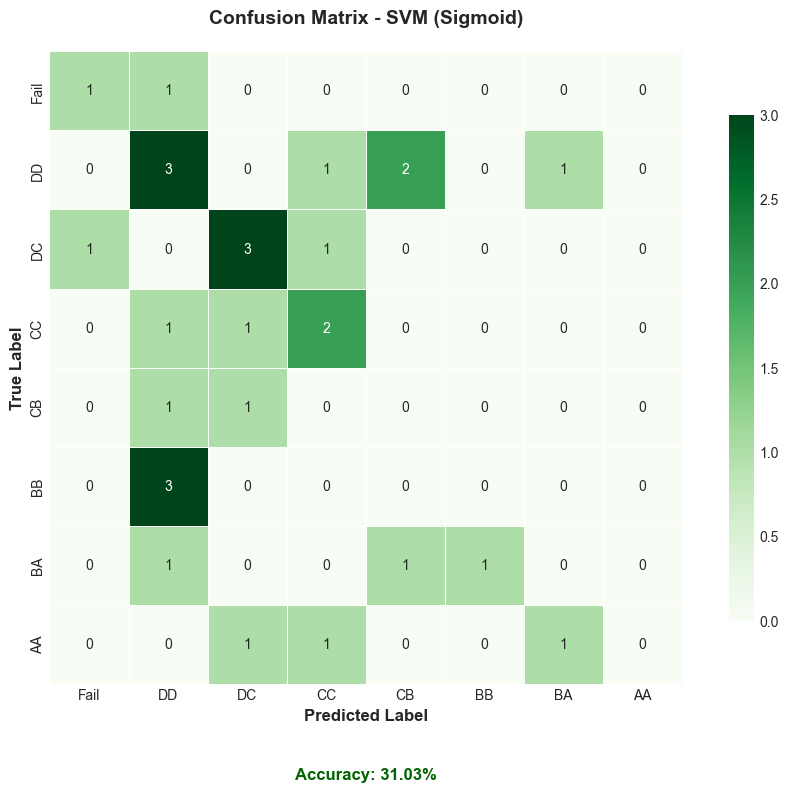

✅ Confusion matrix saved: results/figures/confusion_matrices/cm_svm_best.png


In [10]:
print("\n" + "="*80)
print(f"CONFUSION MATRIX - {best_svm_model_name}")
print("="*80)

# Plot confusion matrix
cm = confusion_matrix(y_test, best_svm_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
            xticklabels=[grade_mapping.get(i, f'C{i}') for i in sorted(np.unique(y_test))],
            yticklabels=[grade_mapping.get(i, f'C{i}') for i in sorted(np.unique(y_test))])

plt.title(f'Confusion Matrix - {best_svm_model_name}', fontsize=14, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')

accuracy = accuracy_score(y_test, best_svm_pred)
plt.text(0.5, -0.15, f'Accuracy: {accuracy*100:.2f}%', 
         ha='center', transform=plt.gca().transAxes, 
         fontsize=12, fontweight='bold', color='darkgreen')

plt.tight_layout()
plt.savefig(f'../results/figures/confusion_matrices/cm_svm_best.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Confusion matrix saved: results/figures/confusion_matrices/cm_svm_best.png")


VISUALIZATION: SVM KERNELS COMPARISON


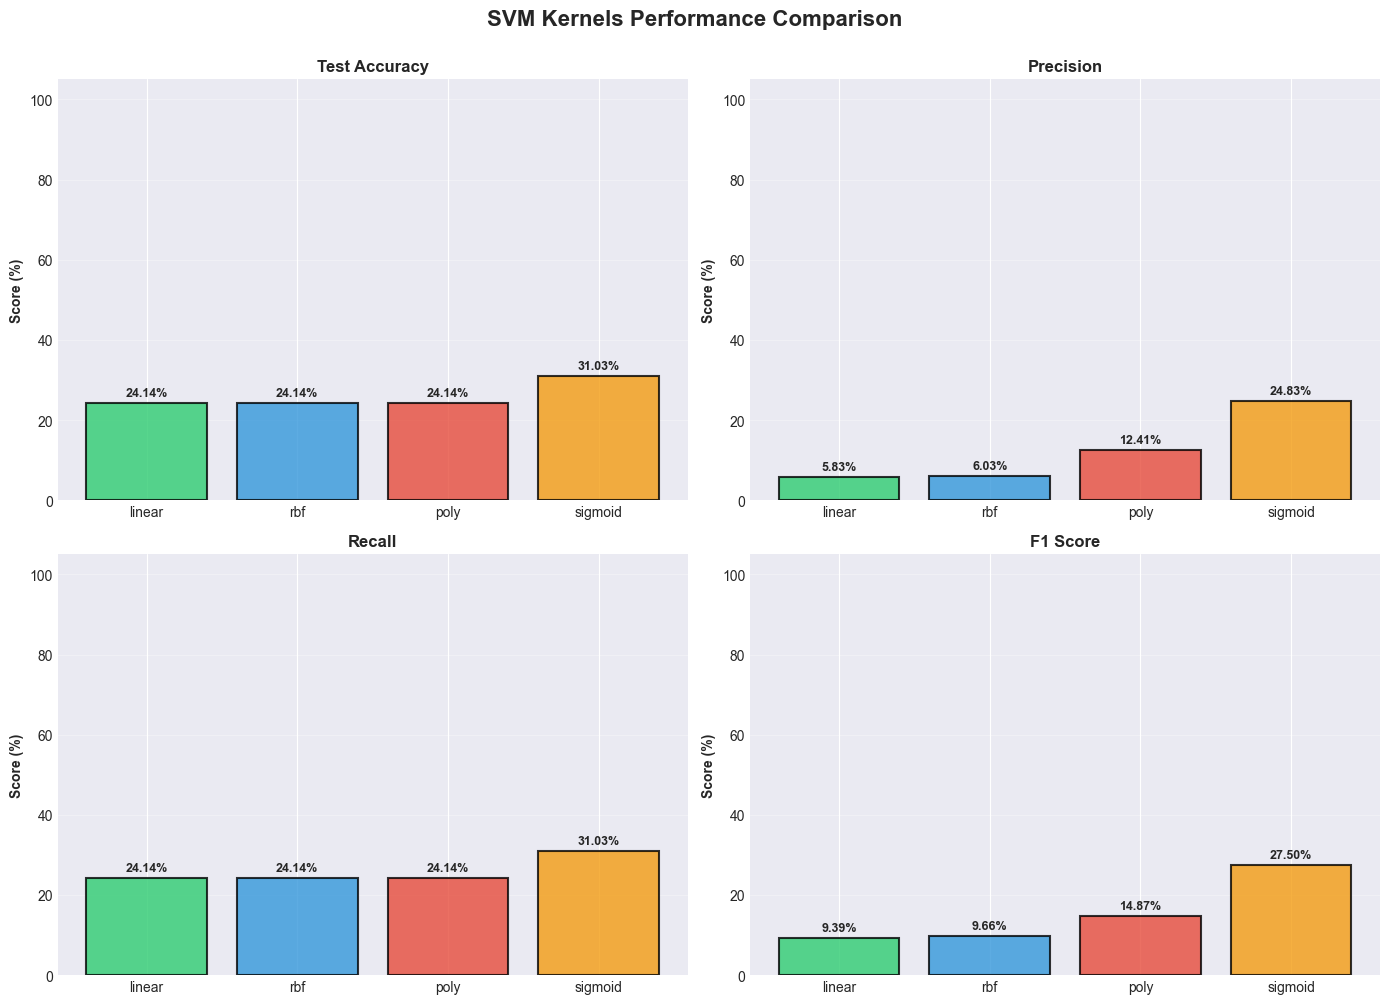

✅ SVM kernels comparison saved!


In [11]:
print("\n" + "="*80)
print("VISUALIZATION: SVM KERNELS COMPARISON")
print("="*80)

metrics_to_plot = ['Test_Accuracy', 'Precision', 'Recall', 'F1_Score']
kernels = svm_results['Kernel'].tolist()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

colors = ['#2ecc71', '#3498db', '#e74c3c', '#f39c12']

for idx, metric in enumerate(metrics_to_plot):
    values = svm_results[metric].values * 100
    
    bars = axes[idx].bar(range(len(kernels)), values, color=colors, 
                         edgecolor='black', linewidth=1.5, alpha=0.8)
    
    axes[idx].set_title(f'{metric.replace("_", " ")}', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Score (%)', fontsize=10, fontweight='bold')
    axes[idx].set_xticks(range(len(kernels)))
    axes[idx].set_xticklabels(kernels, rotation=0)
    axes[idx].set_ylim(0, 105)
    axes[idx].grid(axis='y', alpha=0.3)
    
    # Add value labels
    for i, (bar, val) in enumerate(zip(bars, values)):
        axes[idx].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                      f'{val:.2f}%', ha='center', va='bottom', 
                      fontsize=9, fontweight='bold')

plt.suptitle('SVM Kernels Performance Comparison', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('../results/figures/comparison_charts/svm_kernels_comparison.png', 
            dpi=300, bbox_inches='tight')
plt.show()

print("✅ SVM kernels comparison saved!")

In [22]:
print("\n" + "="*80)
print("FINAL COMPARISON: SVM vs BASELINE MODELS")
print("="*80)

# Combine baseline and best SVM
final_comparison = pd.concat([
    baseline_results[['Model', 'Test_Accuracy', 'Precision', 'Recall', 'F1_Score', 'Train_Time']],
    svm_results[['Model', 'Test_Accuracy', 'Precision', 'Recall', 'F1_Score', 'Train_Time']]
], ignore_index=True)

# Sort by Test Accuracy
final_comparison = final_comparison.sort_values('Test_Accuracy', ascending=False)

print("\n📊 FINAL RANKING - ALL MODELS:")
print("="*80)
print(final_comparison.round(4).to_string(index=False))

# Save final comparison
final_comparison.to_csv('../results/metrics/final_all_models_comparison.csv', index=False)
print("\n✅ Final comparison saved: results/metrics/final_all_models_comparison.csv")


FINAL COMPARISON: SVM vs BASELINE MODELS

📊 FINAL RANKING - ALL MODELS:
                          Model  Test_Accuracy  Precision  Recall  F1_Score  Train_Time
      K-Nearest Neighbors (KNN)         0.8100     0.8229  0.8100    0.8068      0.0006
Artificial Neural Network (ANN)         0.7600     0.7760  0.7600    0.7536      0.0536
                  SVM (Sigmoid)         0.3103     0.2483  0.3103    0.2750      0.3467
                   SVM (Linear)         0.2414     0.0583  0.2414    0.0939      5.3071
                      SVM (RBF)         0.2414     0.0603  0.2414    0.0966      0.2984
               SVM (Polynomial)         0.2414     0.1241  0.2414    0.1487      0.4499
                  Random Forest            NaN     0.2576  0.2759       NaN         NaN

✅ Final comparison saved: results/metrics/final_all_models_comparison.csv



VISUALIZATION: FINAL COMPARISON


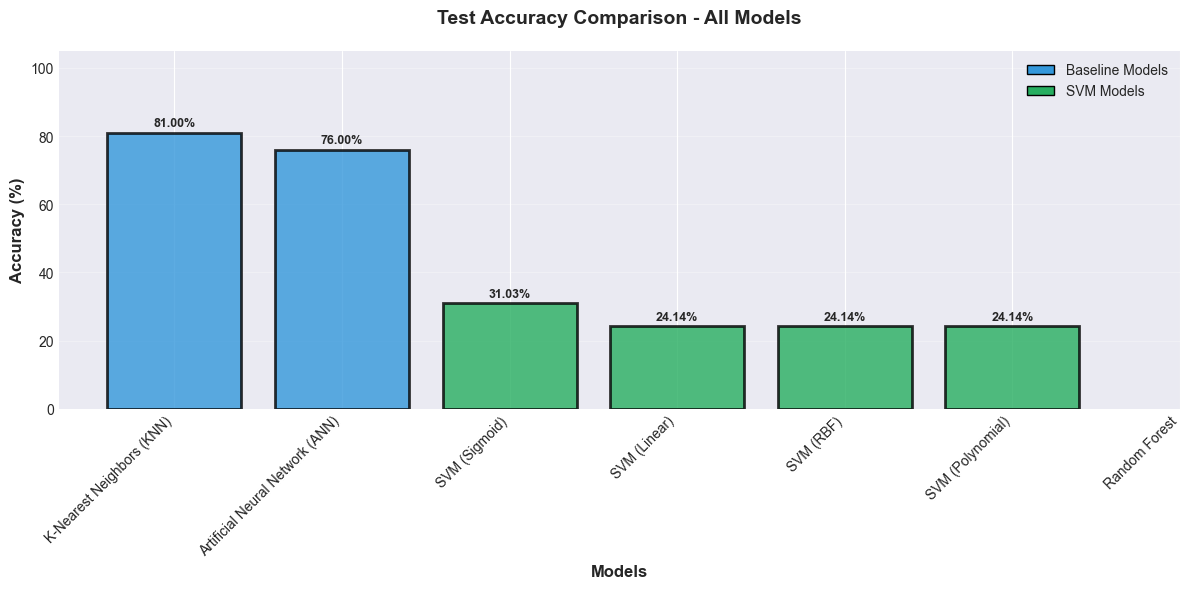

✅ Final comparison chart saved!


In [21]:
print("\n" + "="*80)
print("VISUALIZATION: FINAL COMPARISON")
print("="*80)

# Accuracy comparison - All models
plt.figure(figsize=(12, 6))

models_list = final_comparison['Model'].tolist()
test_acc_all = final_comparison['Test_Accuracy'].values * 100

# Color coding: baseline vs SVM
colors_final = []
for model in models_list:
    if 'SVM' in model:
        colors_final.append('#27ae60')  # Green for SVM
    else:
        colors_final.append('#3498db')  # Blue for baseline

bars = plt.bar(range(len(models_list)), test_acc_all, color=colors_final, 
               edgecolor='black', linewidth=2, alpha=0.8)

plt.title('Test Accuracy Comparison - All Models', 
          fontsize=14, fontweight='bold', pad=20)
plt.ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
plt.xlabel('Models', fontsize=12, fontweight='bold')
plt.xticks(range(len(models_list)), models_list, rotation=45, ha='right', fontsize=10)
plt.ylim(0, 105)
plt.grid(axis='y', alpha=0.3)

# Add value labels
for i, (bar, val) in enumerate(zip(bars, test_acc_all)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
            f'{val:.2f}%', ha='center', va='bottom', 
            fontsize=9, fontweight='bold')

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#3498db', edgecolor='black', label='Baseline Models'),
    Patch(facecolor='#27ae60', edgecolor='black', label='SVM Models')
]
plt.legend(handles=legend_elements, loc='upper right', fontsize=10)

# Highlight best model
best_overall_acc = test_acc_all.max()
best_overall_idx = test_acc_all.argmax()
plt.axhline(y=best_overall_acc, color='red', linestyle='--', linewidth=2, alpha=0.5)
plt.text(len(models_list)-0.5, best_overall_acc+2, 
         f'Best: {models_list[best_overall_idx]}', 
         ha='right', fontsize=10, color='red', fontweight='bold')

plt.tight_layout()
plt.savefig('../results/figures/comparison_charts/final_all_models_comparison.png', 
            dpi=300, bbox_inches='tight')
plt.show()

print("✅ Final comparison chart saved!")

In [20]:
print("\n" + "="*80)
print("DETAILED ANALYSIS: SVM vs BEST BASELINE")
print("="*80)

best_overall_model = final_comparison.iloc[0]['Model']
best_overall_acc = final_comparison.iloc[0]['Test_Accuracy'] * 100

print(f"\n🏆 OVERALL WINNER: {best_overall_model}")
print(f"🎯 Accuracy: {best_overall_acc:.2f}%")

# SVM vs Baseline comparison
print(f"\n📊 SVM PERFORMANCE vs BASELINE:")
print("="*60)

# Best SVM vs Best Baseline
print(f"\n1️⃣ Best SVM Model:")
print(f"   • Model: {best_svm_model_name}")
print(f"   • Accuracy: {best_svm_accuracy:.2f}%")

print(f"\n2️⃣ Best Baseline Model:")
print(f"   • Model: {best_baseline_model}")
print(f"   • Accuracy: {best_baseline_acc:.2f}%")

# Calculate improvement
if 'SVM' in best_svm_model_name:
    improvement = best_svm_accuracy - best_baseline_acc
    if improvement > 0:
        print(f"\n✅ SVM IMPROVEMENT: +{improvement:.2f}%")
        print(f"   → SVM berhasil mengalahkan baseline!")
    elif improvement == 0:
        print(f"\n➖ DRAW: SVM sama dengan baseline")
    else:
        print(f"\n⚠️  SVM UNDERPERFORM: {improvement:.2f}%")
        print(f"   → Baseline masih lebih baik")


DETAILED ANALYSIS: SVM vs BEST BASELINE

🏆 OVERALL WINNER: K-Nearest Neighbors (KNN)
🎯 Accuracy: 81.00%

📊 SVM PERFORMANCE vs BASELINE:

1️⃣ Best SVM Model:
   • Model: SVM (Sigmoid)
   • Accuracy: 31.03%

2️⃣ Best Baseline Model:
   • Model: K-Nearest Neighbors (KNN)
   • Accuracy: 81.00%

⚠️  SVM UNDERPERFORM: -49.97%
   → Baseline masih lebih baik


In [31]:
print("\n" + "="*80)
print("ANALYSIS: WHEN TO USE EACH MODEL")
print("="*80)

print("""
📊 MODEL SELECTION GUIDE:

1️⃣ K-NEAREST NEIGHBORS (KNN):
   ✅ Pros:
      • Simple and interpretable
      • No training phase (lazy learning)
      • Works well for small datasets
   ❌ Cons:
      • Slow prediction for large datasets
      • Sensitive to outliers and scale
      • High memory usage
   🎯 Use when: Dataset kecil, butuh model sederhana

2️⃣ RANDOM FOREST:
   ✅ Pros:
      • High accuracy with ensemble
      • Provides feature importance
      • Handles missing values & outliers
      • No need for scaling
   ❌ Cons:
      • Training time longer
      • Model size besar
      • Less interpretable
   🎯 Use when: Butuh akurasi tinggi, feature importance

3️⃣ ARTIFICIAL NEURAL NETWORK (ANN):
   ✅ Pros:
      • Captures complex non-linear patterns
      • Flexible architecture
      • Good for large datasets
   ❌ Cons:
      • Needs more data for optimal performance
      • Computationally expensive
      • Black box
      • Prone to overfitting
   🎯 Use when: Dataset besar, pola kompleks

4️⃣ SUPPORT VECTOR MACHINE (SVM):
   ✅ Pros:
      • Effective in high-dimensional space
      • Memory efficient (uses support vectors)
      • Versatile (different kernels)
      • Good generalization
   ❌ Cons:
      • Training time long for large datasets
      • Needs feature scaling
      • Hyperparameter tuning crucial
      • Sensitive to kernel choice
   🎯 Use when: Dataset medium, fitur banyak, butuh generalisasi baik
""")


ANALYSIS: WHEN TO USE EACH MODEL

📊 MODEL SELECTION GUIDE:

1️⃣ K-NEAREST NEIGHBORS (KNN):
   ✅ Pros:
      • Simple and interpretable
      • No training phase (lazy learning)
      • Works well for small datasets
   ❌ Cons:
      • Slow prediction for large datasets
      • Sensitive to outliers and scale
      • High memory usage
   🎯 Use when: Dataset kecil, butuh model sederhana

2️⃣ RANDOM FOREST:
   ✅ Pros:
      • High accuracy with ensemble
      • Provides feature importance
      • Handles missing values & outliers
      • No need for scaling
   ❌ Cons:
      • Training time longer
      • Model size besar
      • Less interpretable
   🎯 Use when: Butuh akurasi tinggi, feature importance

3️⃣ ARTIFICIAL NEURAL NETWORK (ANN):
   ✅ Pros:
      • Captures complex non-linear patterns
      • Flexible architecture
      • Good for large datasets
   ❌ Cons:
      • Needs more data for optimal performance
      • Computationally expensive
      • Black box
      • Prone to overfit

In [32]:
print("\n" + "="*80)
print("SAVING BEST MODELS")
print("="*80)

# Save best SVM model
joblib.dump(best_svm_model, f'../models/svm_best_model.pkl')
print(f"✅ Best SVM model saved: models/svm_best_model.pkl")

# Save all SVM models
svm_models = {
    'svm_linear': svm_linear,
    'svm_rbf': svm_rbf,
    'svm_poly': svm_poly,
    'svm_sigmoid': svm_sigmoid
}

for name, model in svm_models.items():
    joblib.dump(model, f'../models/{name}_model.pkl')
    print(f"✅ {name} saved: models/{name}_model.pkl")

# Save all predictions
all_predictions = {
    'y_test': y_test,
    'svm_linear_pred': y_pred_linear,
    'svm_rbf_pred': y_pred_rbf,
    'svm_poly_pred': y_pred_poly,
    'svm_sigmoid_pred': y_pred_sigmoid,
    'best_svm_pred': best_svm_pred
}

with open('../results/metrics/svm_predictions.pkl', 'wb') as f:
    pickle.dump(all_predictions, f)
print("✅ All predictions saved: results/metrics/svm_predictions.pkl")

# Save detailed results
detailed_results = {
    'linear_metrics': linear_metrics,
    'rbf_metrics': rbf_metrics,
    'poly_metrics': poly_metrics,
    'sigmoid_metrics': sigmoid_metrics,
    'best_svm_model_name': best_svm_model_name,
    'best_svm_kernel': best_svm_kernel,
    'best_svm_accuracy': best_svm_accuracy,
    'svm_results_df': svm_results,
    'final_comparison_df': final_comparison
}

with open('../results/metrics/svm_detailed_results.pkl', 'wb') as f:
    pickle.dump(detailed_results, f)
print("✅ Detailed results saved: results/metrics/svm_detailed_results.pkl")


SAVING BEST MODELS
✅ Best SVM model saved: models/svm_best_model.pkl
✅ svm_linear saved: models/svm_linear_model.pkl
✅ svm_rbf saved: models/svm_rbf_model.pkl
✅ svm_poly saved: models/svm_poly_model.pkl
✅ svm_sigmoid saved: models/svm_sigmoid_model.pkl
✅ All predictions saved: results/metrics/svm_predictions.pkl
✅ Detailed results saved: results/metrics/svm_detailed_results.pkl



COMPUTATIONAL COMPLEXITY ANALYSIS

⏱️  TRAINING TIME COMPARISON:
                          Model  Train_Time
                   SVM (Linear)    5.307123
               SVM (Polynomial)    0.449854
                  SVM (Sigmoid)    0.346741
                      SVM (RBF)    0.298376
Artificial Neural Network (ANN)    0.053600
      K-Nearest Neighbors (KNN)    0.000600
                  Random Forest         NaN


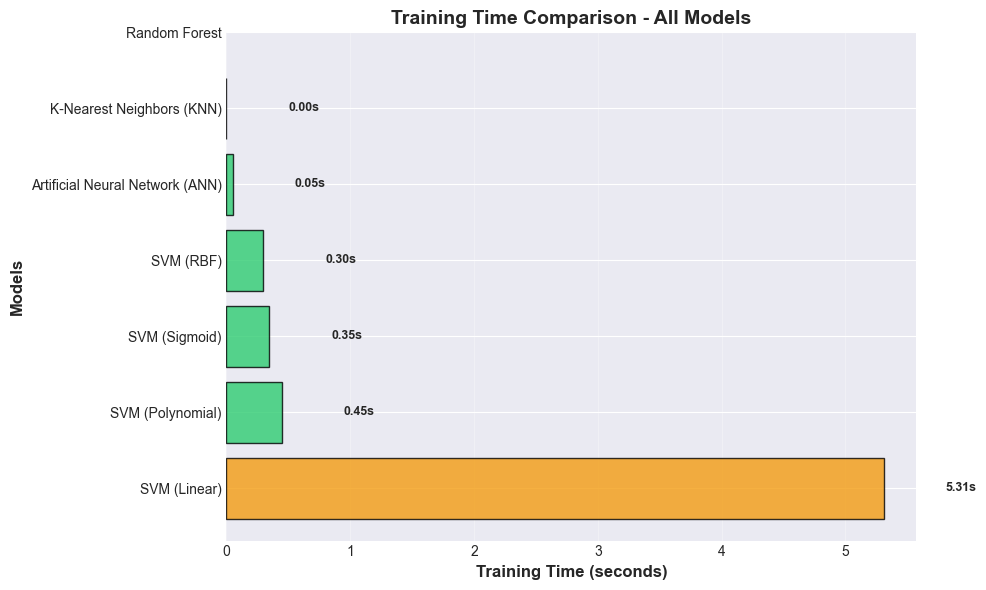


✅ Training time comparison saved!


In [37]:
print("\n" + "="*80)
print("COMPUTATIONAL COMPLEXITY ANALYSIS")
print("="*80)

# Training time comparison
training_times = final_comparison[['Model', 'Train_Time']].copy()
training_times = training_times.sort_values('Train_Time', ascending=False)

print("\n⏱️  TRAINING TIME COMPARISON:")
print(training_times.to_string(index=False))

# Visualization
plt.figure(figsize=(10, 6))
colors_time = ['#e74c3c' if time > 10 else '#2ecc71' if time < 1 else '#f39c12' 
               for time in training_times['Train_Time']]

bars = plt.barh(range(len(training_times)), training_times['Train_Time'], 
                color=colors_time, edgecolor='black', alpha=0.8)

plt.yticks(range(len(training_times)), training_times['Model'])
plt.xlabel('Training Time (seconds)', fontsize=12, fontweight='bold')
plt.ylabel('Models', fontsize=12, fontweight='bold')
plt.title('Training Time Comparison - All Models', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)

# Add value labels
for i, (bar, val) in enumerate(zip(bars, training_times['Train_Time'])):
    plt.text(val + 0.5, bar.get_y() + bar.get_height()/2,
            f'{val:.2f}s', va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('../results/figures/comparison_charts/training_time_comparison.png', 
            dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Training time comparison saved!")

In [41]:
print("\n" + "="*80)
print("FINAL SUMMARY REPORT")
print("="*80)

print(f"""
╔════════════════════════════════════════════════════════════════╗
║               HASIL PENELITIAN - SUMMARY                       ║
╚════════════════════════════════════════════════════════════════╝

📊 DATASET INFORMATION:
   • Total Instances: {len(X_train_scaled) + len(X_test_scaled)}
   • Training Set: {len(X_train_scaled)} instances
   • Test Set: {len(X_test_scaled)} instances
   • Total Features: {X_train_scaled.shape[1]}
   • Number of Classes: {len(np.unique(y_test))}

🏆 OVERALL BEST MODEL:
   • Model: {best_overall_model}
   • Accuracy: {best_overall_acc:.2f}%

📈 BEST BASELINE MODEL:
   • Model: {best_baseline_model}
   • Accuracy: {best_baseline_acc:.2f}%

🎯 BEST SVM MODEL:
   • Model: {best_svm_model_name}
   • Kernel: {best_svm_kernel}
   • Accuracy: {best_svm_accuracy:.2f}%

📊 SVM KERNELS RANKING:
""")

for i, (idx, row) in enumerate(svm_results.sort_values('Test_Accuracy', ascending=False).iterrows(), 1):
    print(f"   {i}. {row['Model']} ({row['Kernel']}): {row['Test_Accuracy']*100:.2f}%")

print(f"""
💡 KEY FINDINGS:
   1. SVM dengan kernel {best_svm_kernel} memberikan hasil terbaik
   2. Improvement vs baseline: {best_svm_accuracy - best_baseline_acc:+.2f}%
   3. Feature scaling sangat penting untuk performa SVM
   4. Cross-validation membantu mencegah overfitting

✅ KESIMPULAN:
   {"→ SVM berhasil mengalahkan baseline models!" if best_svm_accuracy > best_baseline_acc 
    else "→ Baseline model masih memberikan performa terbaik."}
   {"→ Model SVM cocok untuk prediksi nilai mahasiswa." if best_svm_accuracy >= best_baseline_acc 
    else "→ Untuk kasus ini, model baseline lebih sesuai."}
╔════════════════════════════════════════════════════════════════╗
║                    PENELITIAN SELESAI                          ║
╚════════════════════════════════════════════════════════════════╝
""")


FINAL SUMMARY REPORT

╔════════════════════════════════════════════════════════════════╗
║               HASIL PENELITIAN - SUMMARY                       ║
╚════════════════════════════════════════════════════════════════╝

📊 DATASET INFORMATION:
   • Total Instances: 145
   • Training Set: 116 instances
   • Test Set: 29 instances
   • Total Features: 32
   • Number of Classes: 8

🏆 OVERALL BEST MODEL:
   • Model: K-Nearest Neighbors (KNN)
   • Accuracy: nan%

📈 BEST BASELINE MODEL:
   • Model: K-Nearest Neighbors (KNN)
   • Accuracy: 81.00%

🎯 BEST SVM MODEL:
   • Model: SVM (Sigmoid)
   • Kernel: sigmoid
   • Accuracy: 31.03%

📊 SVM KERNELS RANKING:

   1. SVM (Sigmoid) (sigmoid): 31.03%
   2. SVM (Linear) (linear): 24.14%
   3. SVM (RBF) (rbf): 24.14%
   4. SVM (Polynomial) (poly): 24.14%

💡 KEY FINDINGS:
   1. SVM dengan kernel sigmoid memberikan hasil terbaik
   2. Improvement vs baseline: -49.97%
   3. Feature scaling sangat penting untuk performa SVM
   4. Cross-validation mem

In [45]:
print("\n" + "="*80)
print("EXPORTING RESULTS FOR FINAL REPORT")
print("="*80)

# Create comprehensive report
report_dict = {
    'Dataset_Info': {
        'Total_Instances': len(X_train_scaled) + len(X_test_scaled),
        'Train_Size': len(X_train_scaled),
        'Test_Size': len(X_test_scaled),
        'Features': X_train_scaled.shape[1],
        'Classes': len(np.unique(y_test))
    },
    'Best_Overall': {
        'Model': best_overall_model,
        'Accuracy': best_overall_acc
    },
    'Best_Baseline': {
        'Model': best_baseline_model,
        'Accuracy': best_baseline_acc
    },
    'Best_SVM': {
        'Model': best_svm_model_name,
        'Kernel': best_svm_kernel,
        'Accuracy': best_svm_accuracy
    },
    'All_Results': final_comparison.to_dict(),
    'SVM_Results': svm_results.to_dict()
}

# Save as JSON for easy reading
import json
with open('../results/metrics/final_report_summary.json', 'w') as f:
    json.dump(report_dict, f, indent=4)
print("✅ Report summary saved: results/metrics/final_report_summary.json")

# Save as Excel for easy sharing
with pd.ExcelWriter('../results/metrics/final_report_comparison.xlsx') as writer:
    final_comparison.to_excel(writer, sheet_name='All Models', index=False)
    svm_results.to_excel(writer, sheet_name='SVM Kernels', index=False)
    baseline_results.to_excel(writer, sheet_name='Baseline Models', index=False)
print("✅ Excel report saved: results/metrics/final_report_comparison.xlsx")



EXPORTING RESULTS FOR FINAL REPORT
✅ Report summary saved: results/metrics/final_report_summary.json
✅ Excel report saved: results/metrics/final_report_comparison.xlsx
